In [1]:
from __future__ import print_function, division

In [2]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys
from time import time

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [3]:
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import table
from astropy.table import Table

from scipy import stats, integrate

import hosts

In [4]:
%matplotlib inline
from matplotlib import style, pyplot as plt

plt.style.use('seaborn-deep')
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] =  plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] =  plt.rcParams['ytick.labelsize'] = 14

# Load satellite properties

In [5]:
# table from paper
sattab=r"""
    147100 &      1237662224092299404 &    247.840029950 &     20.18407581 &    13.30 &   -19.38 &     0.59 &    21.83 &    -189.3 \\
    147100 &      1237662662147571761 &    248.393225697 &     19.94614008 &    15.63 &   -17.05 &     0.40 &    20.15 &     -62.3 \\
    147100 &      1237662698115432544 &    248.051339587 &     19.69573970 &    16.64 &   -16.04 &     0.38 &    22.37 &    -125.3 \\
    147100 &      1237662662147310256 &    247.825892241 &     20.21087878 &    16.91 &   -15.77 &     0.34 &    23.13 &     -89.3 \\
    147100 &      1237662224092364842 &    247.877387573 &     20.09362484 &    17.00 &   -15.68 &     0.25 &    23.96 &    -109.7 \\
    147100 &      1237662698115432783 &    248.152079686 &     19.81025914 &    17.62 &   -15.06 &     0.29 &    23.45 &      88.2 \\
    147100 &      1237662224092496776 &    248.195368592 &     19.86701268 &    18.56 &   -14.12 &     0.23 &    23.17 &     -95.3 \\
    147100 &      1237662662147703369 &    248.580796850 &     19.72003490 &    19.27 &   -13.41 &     0.34 &    24.32 &     -98.3 \\
    147100 &      1237662698115433445 &    248.163426840 &     19.79220759 &    20.32 &   -12.35 &     0.19 &    23.52 &     135.3 \\
    150887 &      1237679005021831220 &    348.643816258 &      4.49844349 &    12.71 &   -20.13 &     0.68 &    20.06 &      15.0 \\
    150887 &      1237678777399443498 &    348.696648891 &      4.63995487 &    14.96 &   -17.88 &     0.19 &    21.79 &    -175.8 \\
    150887 &      1237678776862572690 &    348.776907636 &      4.37319701 &    15.61 &   -17.23 &     0.55 &    20.75 &      19.7 \\
    150887 &      1237679005021831801 &    348.621488524 &      4.50717078 &    17.79 &   -15.05 &     0.55 &    23.55 &     104.8 \\
    150887 &      1237678777399509170 &    348.874199097 &      4.61326147 &    19.89 &   -12.95 &     0.46 &    22.57 &     -17.8 \\
    150887 &      1237679005558702536 &    348.554591739 &      4.91500327 &    20.69 &   -12.15 &     0.21 &    23.67 &    -119.5 \\
    149781 &      1237680192048857102 &    336.048161241 &     -3.48293869 &    13.50 &   -19.46 &     0.41 &    22.50 &      -5.0 \\
    149781 &      1237680066954264778 &    335.836305444 &     -3.65980264 &    14.86 &   -18.10 &     0.56 &    21.80 &    -233.0 \\
    149781 &      1237679996084617517 &    335.979976180 &     -3.27054859 &    15.91 &   -17.06 &     0.58 &    21.42 &     -23.0 \\
    149781 &      1237680066954330699 &    335.953849494 &     -3.70119482 &    19.44 &   -13.52 &     0.18 &    23.80 &      21.9 \\
    149781 &      1237679996084749053 &    336.309678056 &     -3.37093808 &    21.61 &   -11.36 &     0.35 &    24.08 &     159.9 \\
     61945 &      1237666408439939282 &    354.350599991 &      0.39080277 &    13.66 &   -19.04 &     0.41 &    23.67 &    -102.5 \\
     61945 &      1237663277925204111 &    354.195229736 &      0.62342377 &    15.62 &   -17.09 &     0.41 &    22.88 &     -88.9 \\
     61945 &      1237666408439677694 &    353.778805283 &      0.30105852 &    21.28 &   -11.43 &     1.39 &    23.15 &     158.4 \\
    166313 &      1237665565541728490 &    234.132926177 &     16.44045529 &    14.28 &   -17.95 &     0.51 &    22.11 &      71.9 \\
    166313 &      1237665566078402826 &    233.787037531 &     16.87043760 &    15.40 &   -16.84 &     0.38 &    22.51 &     -32.5 \\
     33446 &      1237657607497318756 &    123.243173206 &     36.19835997 &    15.40 &   -17.48 &     0.30 &    21.51 &     -19.7 \\
     33446 &      1237657607497515484 &    123.649897556 &     36.43435540 &    16.37 &   -16.52 &     0.35 &    23.02 &       8.0 \\
    165536 &      1237648721248845970 &    221.316115836 &     -0.15993708 &    14.90 &   -17.13 &     0.41 &    21.62 &     -28.5 \\
    132339 &      1237678881574944900 &     39.925464253 &     -1.41874191 &    16.96 &   -15.89 &     0.35 &    21.15 &      -5.9 \\
    132339 &      1237678881574814166 &     39.536161339 &     -1.39669558 &    20.10 &   -12.75 &     0.06 &    24.23 &      95.8 \\
"""
sattab = Table.read(sattab.split('\n'), format='ascii.latex', data_start=1,
                    names=['NSAID', 'objid', 'ra', 'dec', 'r', 'M_r', 'g-r', 'mur', 'dv'])

In [6]:
hostobjs = hosts.get_saga_hosts_from_google()

seps = []
ds = []
for sat in sattab:
    h = [h for h in hostobjs if h.nsaid == sat['NSAID']]
    assert len(h)==1
    h = h[0]
    satsc = SkyCoord(sat['ra'], sat['dec'], unit=u.deg)
    
    sep = satsc.separation(h.coords)
    seps.append(sep.arcmin)
    ds.append((h.dist * sep.radian).to(u.kpc).value)
    
sattab['sep'] = seps*u.arcmin
sattab['R_host'] = ds*u.kpc

Using cached version of google hosts list from file "hosts_dl.pkl2"


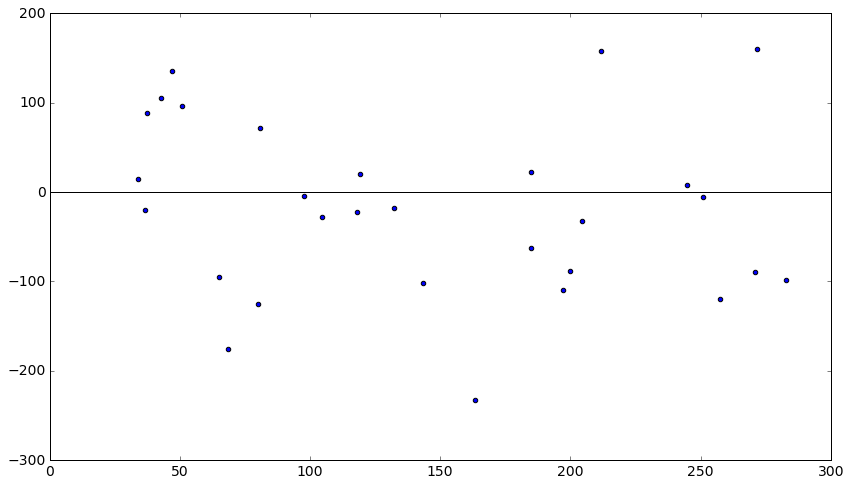

In [7]:
plt.scatter(sattab['R_host'], sattab['dv'])
plt.axhline(0, c='k')

In [8]:
ngtr = np.sum(sattab['dv'] > 0)
nless = np.sum(sattab['dv'] < 0)
ngtr, nless

(11, 18)

In [9]:
stats.binom(ngtr+nless, 0.5).cdf(11)

0.13246544823050499

$B(x, n, p)$ = Binomial

$\frac{P(more \, above|D)}{P(equal|D)} = B(n_a, n_a+n_b, \frac{1}{2}) / \int B(n_a, n_a+n_b, p) P(p) dp$

(assuming unity prior ratio)

If we take $P(p) = U(0, 1)$:

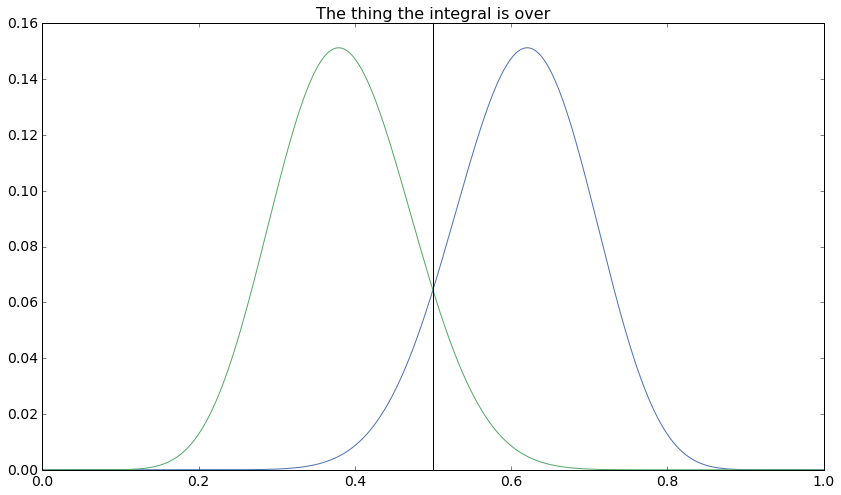

In [10]:
px = np.linspace(0, 1, 1000)
plt.plot(px, stats.binom.pmf(nless, nless+ngtr, px))
plt.plot(px, stats.binom.pmf(ngtr, nless+ngtr, px))
plt.axvline(0.5, color='k')
plt.xlim(0,1)
plt.title('The thing the integral is over')

1.9332742318511

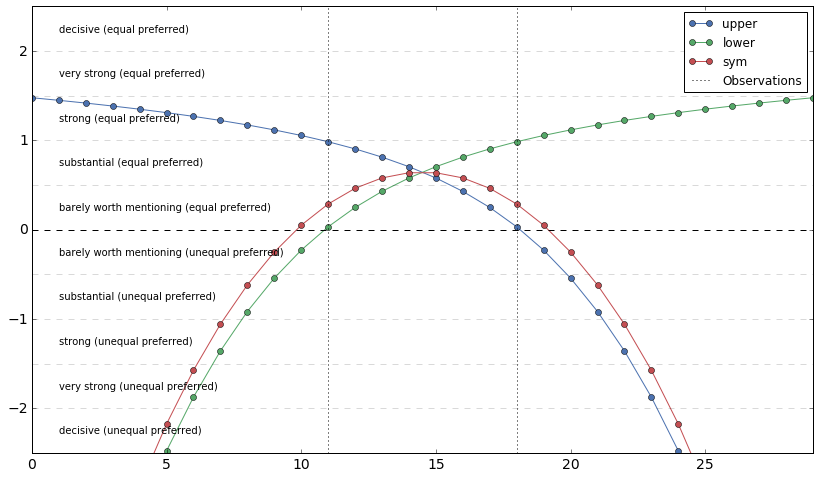

In [11]:
upperratio = []
lowerratio = []
symratio = []

ntot = nless+ngtr

for ni in range(ntot+1):
    ur = stats.binom.pmf(ni, ntot, 0.5)/(integrate.quad(lambda p: stats.binom.pmf(ni, ntot, p), 0.5, 1)[0]*2)
    lr = stats.binom.pmf(ni, ntot, 0.5)/(integrate.quad(lambda p: stats.binom.pmf(ni, ntot, p), 0., 0.5)[0]*2)
    r = stats.binom.pmf(ni, ntot, 0.5)/(integrate.quad(lambda p: stats.binom.pmf(ni, ntot, p), 0., 1)[0])
    upperratio.append(ur)
    lowerratio.append(lr)
    symratio.append(r)
    
plt.plot(np.arange(ntot+1), np.log10(upperratio), 'o-', label='upper')
plt.plot(np.arange(ntot+1), np.log10(lowerratio), 'o-', label='lower')
plt.plot(np.arange(ntot+1), np.log10(symratio), 'o-', label='sym')

plt.axhline(0, c='k', ls='--')

for sig, name in {.5:'barely worth mentioning', 
                  1: 'substantial', 
                  1.5:'strong', 
                  2: 'very strong', 
                  2.5:'decisive'}.items():
    plt.text(1, sig-.25, name + ' (equal preferred)', va='center')
    plt.text(1, -sig+.25, name + ' (unequal preferred)', va='center')
    plt.axhline(sig, c='k', ls='--', alpha=.15)
    plt.axhline(-sig, c='k', ls='--', alpha=.15)

    
plt.axvline(nless, c='k', ls=':', label='Observations')
plt.axvline(ngtr, c='k', ls=':')

plt.legend(loc=0)
plt.xlim(0, ntot)
plt.ylim(-2.5, 2.5)


stats.binom.pmf(nless, nless+ngtr, 0.5)/integrate.quad(lambda p: stats.binom.pmf(nless, nless+ngtr, p), 0, 1)[0]